In [1]:
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Iterable
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [2]:
%matplotlib inline

In [3]:
# set seaborn style
sns.set_style('darkgrid')

In [4]:
class GloVe:
    def __init__(self, glove_file: str):
        self.embeddings_dict = dict()
        self._words = list()
        with open(glove_file, 'r', encoding="utf-8") as f:
            for i, line in enumerate(f):
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                self.embeddings_dict[word] = vector
                self._words.append(word)

                if i % 100000 == 0:
                    print(f"Processed {i} items")

        print(f"Loaded the file: {glove_file}")
        print(f"Number of words: {len(self._words)}")

    def __getitem__(self, key: str) -> np.ndarray:
        ret = self.embeddings_dict[key]
        return ret

    @property
    def words(self) -> List[str]:
        ret = list(self._words)
        return ret

    @words.setter
    def words(self, val: Iterable[str]):
        words = []
        for w in val:
            if w not in self.embeddings_dict:
                continue
            else:
                words.append(w)

        self._words = words

    def find_nearest(self, words: List[str], k: int = 5, metric: str = 'cosine'):
        """
        Reference
        ----------
        https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
        """
        input_ = [self[w] for w in words]
        ret = self.find_nearest_by_vecs(input_, k=k, metric=metric)
        return ret

    def find_nearest_by_vecs(self, vecs: List[np.ndarray], k=5, metric='cosine'):
        # gram-matrix
        X = np.array([self[w] for w in self._words])
        neigh = NearestNeighbors(n_neighbors=k, metric=metric)
        neigh.fit(X)  # fit the model
        dists, w_idxs = neigh.kneighbors(
            vecs, n_neighbors=k, return_distance=True)
        n_words, _ = dists.shape

        ret = []
        for i in range(n_words):
            tmp = []
            words = [self._words[idx] for idx in w_idxs[i]]
            for w, d in zip(words, dists[i]):
                tmp.append((w, d))
            ret.append(tmp)
        return ret

    def find_nearest_by_vec(self, vec: np.ndarray, k: int = 5, metric: str = 'cosine'):
        rets = self.find_nearest_by_vecs([vec], k=k, metric=metric)
        # return only the first one
        ret = rets[0]
        return ret

    def get_emb_vecs_of(self, words: List[str]) -> Dict[str, np.ndarray]:
        ret = {w: self[w] for w in words}
        return ret

In [5]:
class WordSampler:
    def __init__(self, file, incl_words: Iterable[str], n_samples=10000, random_state=40):
        with open(file, "r", encoding="utf-8") as f:
            self._words = f.read().splitlines()

        print(f"{file} has {len(self._words)} words.")
        avaliable = set(self._words).intersection(incl_words)
        print("# of words intersect with `incl_words`: ", len(avaliable))

        # select n_samples data
        rnd_state = np.random.RandomState(random_state)
        self._selected = rnd_state.choice(
            list(avaliable), size=n_samples, replace=False)
        assert len(set(self._selected)) == n_samples

    @property
    def words(self) -> List[str]:
        return self._selected

In [6]:
def get_kmean_model(n_clusters: int):
    """
    Simple factory method to generate a kmean clusterer with pre-config params
    """
    ret = KMeans(init="k-means++", n_clusters=n_clusters,
                 random_state=10, verbose=0)
    return ret

In [7]:
class PlotConfig:
    """
    Plot related configuration
    """
    figsize = (18, 7)

plt_cfg = PlotConfig()

In [8]:
# load the glove data
glove = GloVe("glove/glove.6B.300d.txt")
# make a sampler
sampler = WordSampler("./words_alpha.txt",
                      incl_words=glove.words, n_samples=10000)
# sample words from the sampler
sampled_words = sampler.words
# set our embedding model use sampled words
glove.words = sampled_words

Processed 0 items
Processed 100000 items
Processed 200000 items
Processed 300000 items
Loaded the file: glove/glove.6B.300d.txt
Number of words: 400000
./words_alpha.txt has 370099 words.
# of words intersect with `incl_words`:  100776


#### Obtain the embedding vectors from the sampled words

In [9]:
emb_vecs = glove.get_emb_vecs_of(sampled_words)

#### Build the data-matrix with shape: ``(n_samples, emb_dims)``

In [10]:
X = np.array([emb_vecs[w] for w in sampled_words])
# L2-normalize all the vectors as we would like to use the cosine distance metric
# See also: https://stats.stackexchange.com/a/146279
length = np.sqrt((X**2).sum(axis=1))[:, None]
X = X / length

 ## Selecting the number of clusters
 Consider the **elbow method** and the **silhouette method** to determine the number of clusters.
 Given the fact that the more clusters we have, the easier we assign the "concept" to each cluster.
 However, we would like to visualize the results and therefore we search the number of clusters **from 3 to 15**.

In [11]:
# ----------------------------------------------------------------------
# Load or generate statistics for determining the number of clusters
# ----------------------------------------------------------------------
k_mean_stat = Path("results/kmean_cluster_err_stat.json")
if k_mean_stat.exists():
    with k_mean_stat.open("r") as f:
        km_stat_dict = json.load(f)
    list_k = km_stat_dict["n_clusters"]
    print(f"Loaded the {k_mean_stat}")
else:
    list_k = list(range(3, 15+1))
    # formulate the data and save it
    km_stat_dict = {
        "n_clusters": [],   # Number of clusters
        "wss": [],  # Within-Cluster-Sum of Squared Errors
        "mean_sil_coeff": [],  # Mean Silhouette Coefficient
        "time_used": []
    }
    for k in list_k:
        stime = time.time()
        km = get_kmean_model(k)
        labels = km.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        time_used = time.time() - stime
        print(f"n_clusters: {k}; "
              f"inertia: {km.inertia_:.3f}; "
              f"mean_sil_coeff: {silhouette_avg:.3f}; "
              f"time_used: {time_used:.2f}")
        km_stat_dict["n_clusters"].append(k)
        km_stat_dict["wss"].append(float(km.inertia_))
        km_stat_dict["mean_sil_coeff"].append(float(silhouette_avg))
        km_stat_dict["time_used"].append(time_used)

    # formulate the data and save it as cache
    print(f"Saving the statistics to {k_mean_stat}")
    with k_mean_stat.open("w") as f:
        json.dump(km_stat_dict, f, indent=1)

n_clusters: 3; inertia: 9009.571; mean_sil_coeff: 0.022; time_used: 14.25
n_clusters: 4; inertia: 8950.290; mean_sil_coeff: 0.021; time_used: 12.51
n_clusters: 5; inertia: 8908.625; mean_sil_coeff: 0.008; time_used: 9.01
n_clusters: 6; inertia: 8867.576; mean_sil_coeff: 0.008; time_used: 7.71
n_clusters: 7; inertia: 8833.974; mean_sil_coeff: 0.007; time_used: 7.65
n_clusters: 8; inertia: 8801.264; mean_sil_coeff: 0.007; time_used: 9.68
n_clusters: 9; inertia: 8774.883; mean_sil_coeff: 0.008; time_used: 12.06
n_clusters: 10; inertia: 8751.666; mean_sil_coeff: 0.007; time_used: 9.40
n_clusters: 11; inertia: 8730.695; mean_sil_coeff: 0.006; time_used: 9.01
n_clusters: 12; inertia: 8714.893; mean_sil_coeff: 0.006; time_used: 11.14
n_clusters: 13; inertia: 8697.585; mean_sil_coeff: 0.006; time_used: 23.55
n_clusters: 14; inertia: 8682.032; mean_sil_coeff: 0.006; time_used: 9.33
n_clusters: 15; inertia: 8666.614; mean_sil_coeff: 0.007; time_used: 15.47
Saving the statistics to results/kmean_

In [12]:
km_stat = pd.DataFrame.from_dict(km_stat_dict)
km_stat = km_stat.reset_index()

In [13]:
km_stat

,index,n_clusters,wss,mean_sil_coeff,time_used
0,0,3,9009.571289,0.022284,14.251992
1,1,4,8950.290039,0.020643,12.507955
2,2,5,8908.625000,0.007571,9.013689
3,3,6,8867.576172,0.008402,7.714473
4,4,7,8833.973633,0.006678,7.647395
5,5,8,8801.263672,0.007372,9.683293
6,6,9,8774.882812,0.007564,12.059101
7,7,10,8751.666016,0.006655,9.401378
8,8,11,8730.695312,0.006160,9.009853
9,9,12,8714.892578,0.005788,11.138670


 ### Elbow Method
 Generally speaking, the within cluster SSE decreases as the number of clusters \
 increase. We would like to find the plot of the point of inflection on the curve.
 Geometrically, we would like to find the point at which the curvature of the curve is
 maximum.

 A two-dimensional curve of a 1-d function:
   $g(x,y) = f(x) - y = 0$

 The curvature is:
   $\kappa = \frac{f''}{(1+{f'}^{2})^{3/2}}$

 See the knee definition in:
   https://raghavan.usc.edu//papers/kneedle-simplex11.pdf

In [14]:
kneedle = KneeLocator(km_stat["n_clusters"], km_stat["wss"],
                      S=1.0, curve='convex', direction='decreasing', online=False, interp_method="interp1d")
print("The number of cluster according to elbow method:", kneedle.knee)
print("The corresponding Within-Cluster-Sum of Squared Errors (WSS):", kneedle.knee_y)

The number of cluster according to elbow method: 8
The corresponding Within-Cluster-Sum of Squared Errors (WSS): 8801.263671875


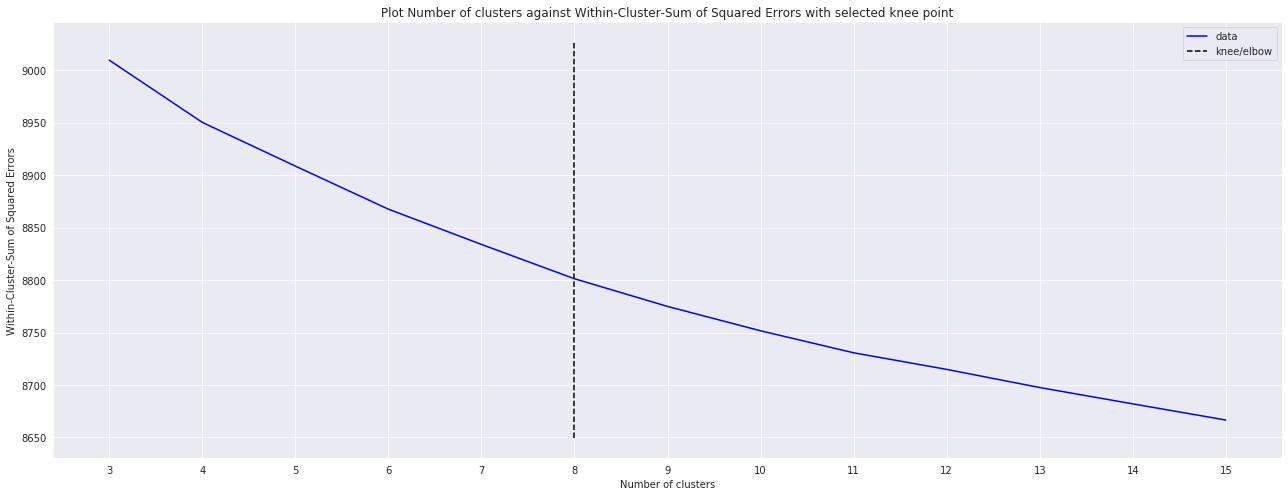

In [15]:
# Plot Number of clusters against Within-Cluster-Sum of Squared Errors
kneedle.plot_knee(figsize=plt_cfg.figsize)
plt.xlabel("Number of clusters")
plt.ylabel("Within-Cluster-Sum of Squared Errors")
plt.xticks(np.arange(min(list_k), max(list_k)+1, 1))
plt.title(f"Plot Number of clusters against Within-Cluster-Sum of Squared Errors with selected knee point")
plt.tight_layout()
plt.savefig("results/knee.png")
plt.show()

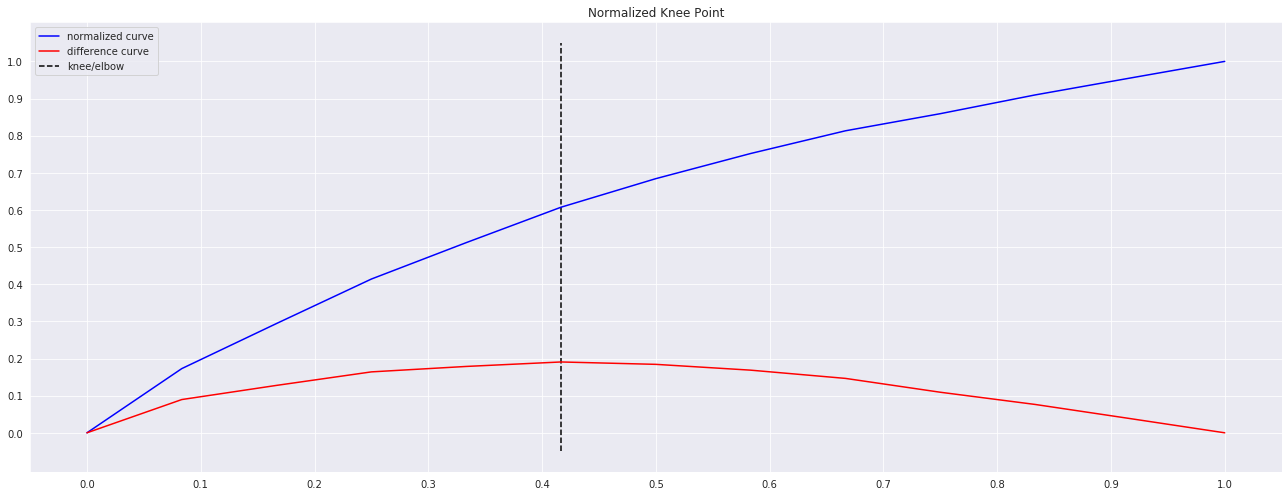

In [16]:
# Plot the normalized knee curves
kneedle.plot_knee_normalized(figsize=plt_cfg.figsize)
plt.tight_layout()
plt.savefig("results/knee_normalized.png")
plt.show()

 ### The Silhouette Method

 The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

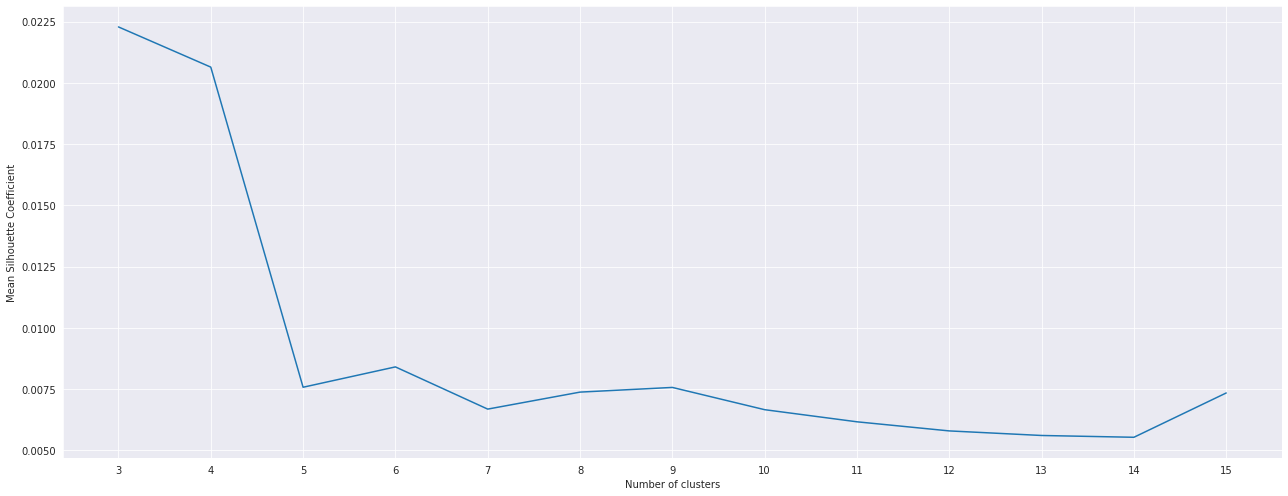

In [17]:
plt.subplots(figsize=plt_cfg.figsize)
ax = sns.lineplot(x="n_clusters",
                  y="mean_sil_coeff", data=km_stat)
ax.set(xlabel="Number of clusters",
       ylabel="Mean Silhouette Coefficient")
plt.xticks(np.arange(min(list_k), max(list_k)+1, 1))
plt.tight_layout()
plt.savefig("results/n_clusters_against_silhouette_score.png")
plt.show()

 The Elbow Method does not have a clear suggestion because the change of slope is not obvious.
 The Silhouette Method suggests number of clusters to be 3, 4, or 5.

 Combine two information, I would show the clustering with ``n_clusters`` = 5

In [18]:
# ----------------------
# Do clustering
# ----------------------
n_clusters = 5
km = get_kmean_model(n_clusters)
labels = km.fit_predict(X)

In [19]:
# build a dataframe which has word and labels
data = pd.DataFrame({
    "word": sampled_words,
    "label": labels
})
# samples words from each cluster
sampled_word_df = (data.sample(frac=1, random_state=0)   # shuffle
                       .groupby("label", sort=False).head(10))

print("Sampled words from each label")
print("----------------------------------")
for i in range(n_clusters):
    words = sampled_word_df[sampled_word_df["label"] == i]["word"].to_list()
    print(i, ":", ", ".join(words))

Sampled words from each label
----------------------------------
0 : few, him, exceeding, remarked, withdrawals, depleted, nuts, moreover, junior, association
1 : mylohyoid, cantuta, loupe, annelida, chandlery, canonists, trichinopoly, gyroplane, chewie, chappy
2 : meck, serge, eddie, brasserie, scotsman, corgi, smasher, lyonnais, venerated, y
3 : ferryboats, coachwork, horseplayers, tilework, cartouches, noisemaker, explorable, decapods, chevre, erosive
4 : discombobulated, melodious, uninformed, emp, headband, gills, birthing, midafternoon, mortals, hamming


In [20]:
# find the cluster centers and 5 words around each center
print("Cluster centers and 5 words around each center")
print("----------------------------------")
word_to_label = dict()
for i, v in enumerate(km.cluster_centers_):
    nearests = glove.find_nearest_by_vec(v)
    print(f"label {i}: nearest words and distances:")
    print(nearests)
    # save down the cluster center to word
    # use it as the label when plotting out the data
    # avoid to use the same word different labels
    for w, _ in nearests:
        if w not in word_to_label:
            word_to_label[w] = i
            break
label_to_word = {v: k for k, v in word_to_label.items()}

Cluster centers and 5 words around each center
----------------------------------
label 0: nearest words and distances:
[('even', 0.17894351), ('they', 0.22632176), ('more', 0.25037104), ('any', 0.2764902), ('such', 0.28956217)]
label 1: nearest words and distances:
[('pyramidella', 0.26682538), ('coelogyne', 0.28380787), ('weinmannia', 0.29523766), ('vangueria', 0.30634564), ('calliphora', 0.30719084)]
label 2: nearest words and distances:
[('wich', 0.5548203), ('surmises', 0.56130314), ('pyramidella', 0.56226546), ('barmaid', 0.58491015), ('milly', 0.5857826)]
label 3: nearest words and distances:
[('pyramidella', 0.3754285), ('vangueria', 0.39843565), ('superfluity', 0.40015012), ('disconcert', 0.4066857), ('azotobacter', 0.40859222)]
label 4: nearest words and distances:
[('mindlessly', 0.43382323), ('speechifying', 0.47405094), ('emoting', 0.4800474), ('rebelliousness', 0.4832561), ('idiotic', 0.48580766)]


### Use PCA to visualize word vectors on 2d plot

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

In [22]:
# add pca_data for visualization
data["pca_x"] = pca_result[:, 0]
data["pca_y"] = pca_result[:, 1]

In [23]:
def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, label_to_txt: dict) -> Axes:
    """
    Helper function the plot the scatter plot
    """
    n_clusters = len(df["label"].unique())
    fig, ax = plt.subplots(figsize=(16, 10))

    scatter_palette = sns.color_palette("hls", n_clusters)
    txt_palette = sns.color_palette("hls", n_clusters, desat=0.6)
    for i in range(n_clusters):
        plt.scatter(
            x=df.loc[df['label'] == i, x_col],
            y=df.loc[df['label'] == i, y_col],
            color=scatter_palette[i],
            alpha=0.1)
        # find the location of the text
        xtext, ytext = df.loc[df['label'] == i, [x_col, y_col]].mean()
        # set up the box around the text
        bbox_props = dict(boxstyle="round,pad=0.3",
                          fc=txt_palette[i], alpha=0.8, lw=1)
        plt.annotate(label_to_txt[i], (xtext, ytext),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=15, color='k', bbox=bbox_props, alpha=0.8)
    return ax

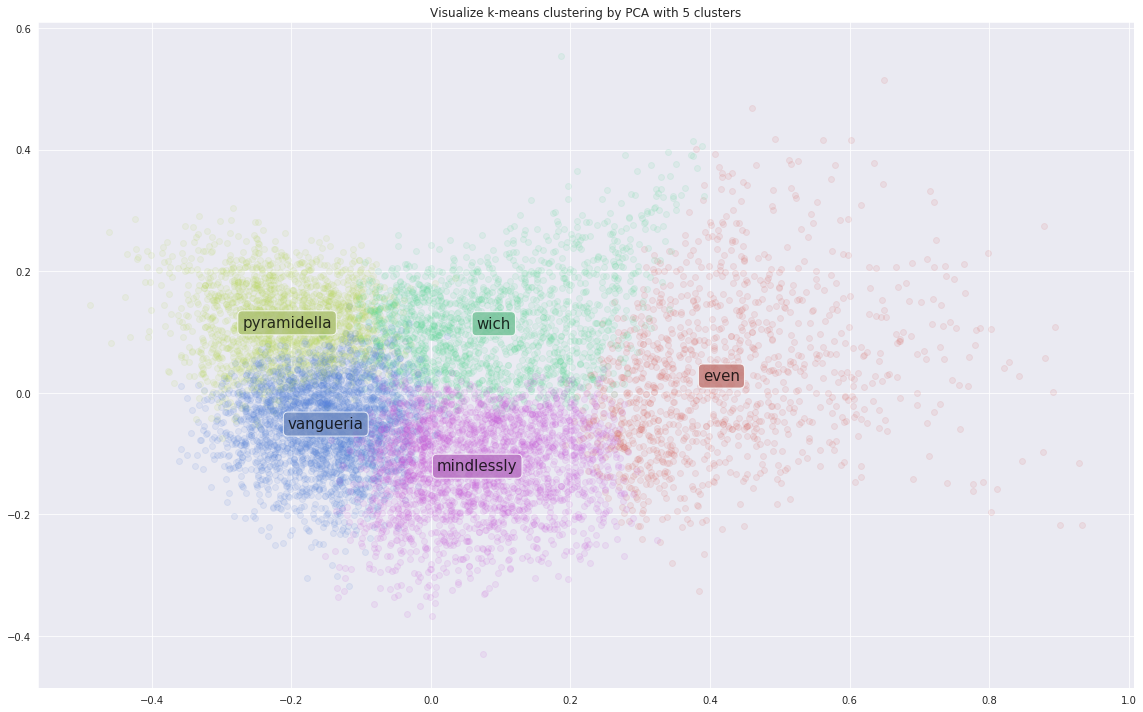

In [24]:
plot_scatter(data, "pca_x", "pca_y", label_to_word)
plt.title(f'Visualize k-means clustering by PCA with {n_clusters} clusters')
plt.tight_layout()
plt.savefig("results/pca_visual.png")
plt.show()

### Use t-SNE to visualize word vectors on 2d plot

In [25]:
time_start = time.time()
# More info on how to grab the perplexity and iterations:
# https://distill.pub/2016/misread-tsne/
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500)
tsne_result = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.362s...
[t-SNE] Computed neighbors for 10000 samples in 58.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.263390
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.007370
[t-SNE] KL divergence after 500 iterations: 3.191690
t-SNE done! Time elapsed

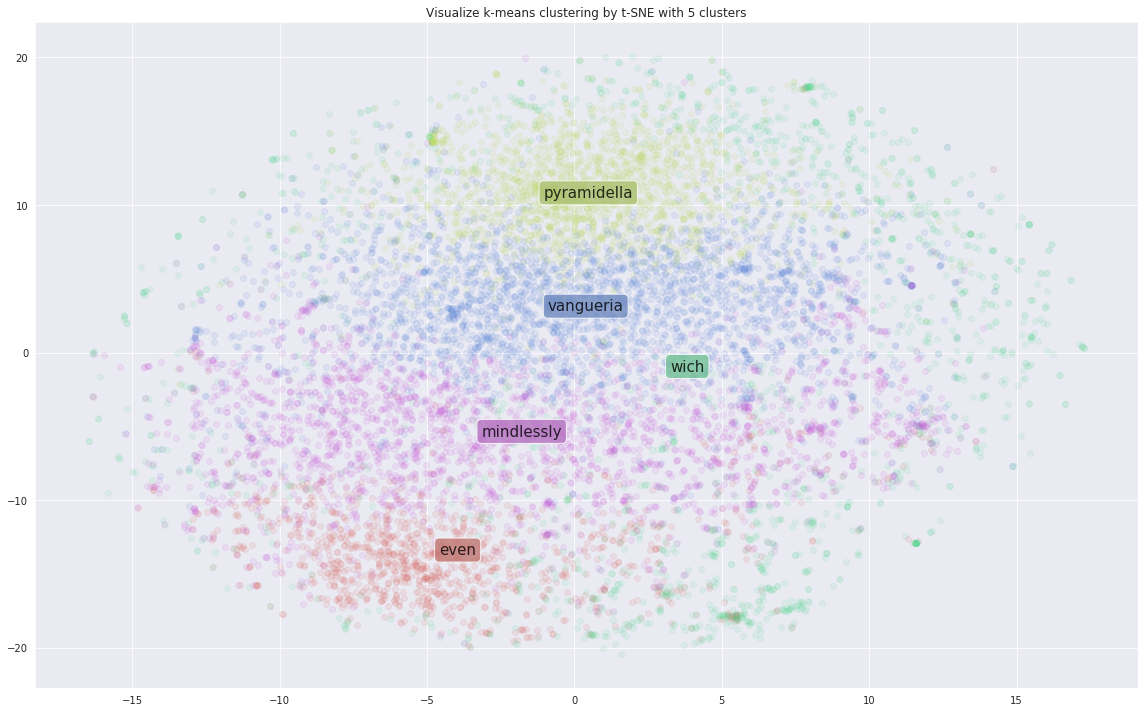

In [26]:
data["tsne_x"] = tsne_result[:, 0]
data["tsne_y"] = tsne_result[:, 1]

plot_scatter(data, "tsne_x", "tsne_y", label_to_word)
plt.title(f'Visualize k-means clustering by t-SNE with {n_clusters} clusters')
plt.tight_layout()
plt.savefig("results/tsne_visual.png")
plt.show()